## Binary classification using: resnet

In [1]:
# libraries 

import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import cv2

import tensorflow as tf
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns 

import pandas as pd 
import numpy as np

from sklearn.utils import class_weight

import sklearn


2023-07-31 10:08:29.497580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
train_dir = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/binary/train/'
val_dir = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/binary/val/'
test_dir = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/binary/test'

## Variables


In [6]:
IMAGE_SIZE = 256
EPOCH = 30

# Image Pre-processing 

In [7]:
def custom_preprocessing(image):
    return cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 5) ,-4 ,128)
    
    

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = custom_preprocessing
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=24,
)

Found 2930 images belonging to 2 classes.


In [10]:
class_labels = list(train_generator.class_indices.keys())
class_labels

['DR', 'No_DR']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

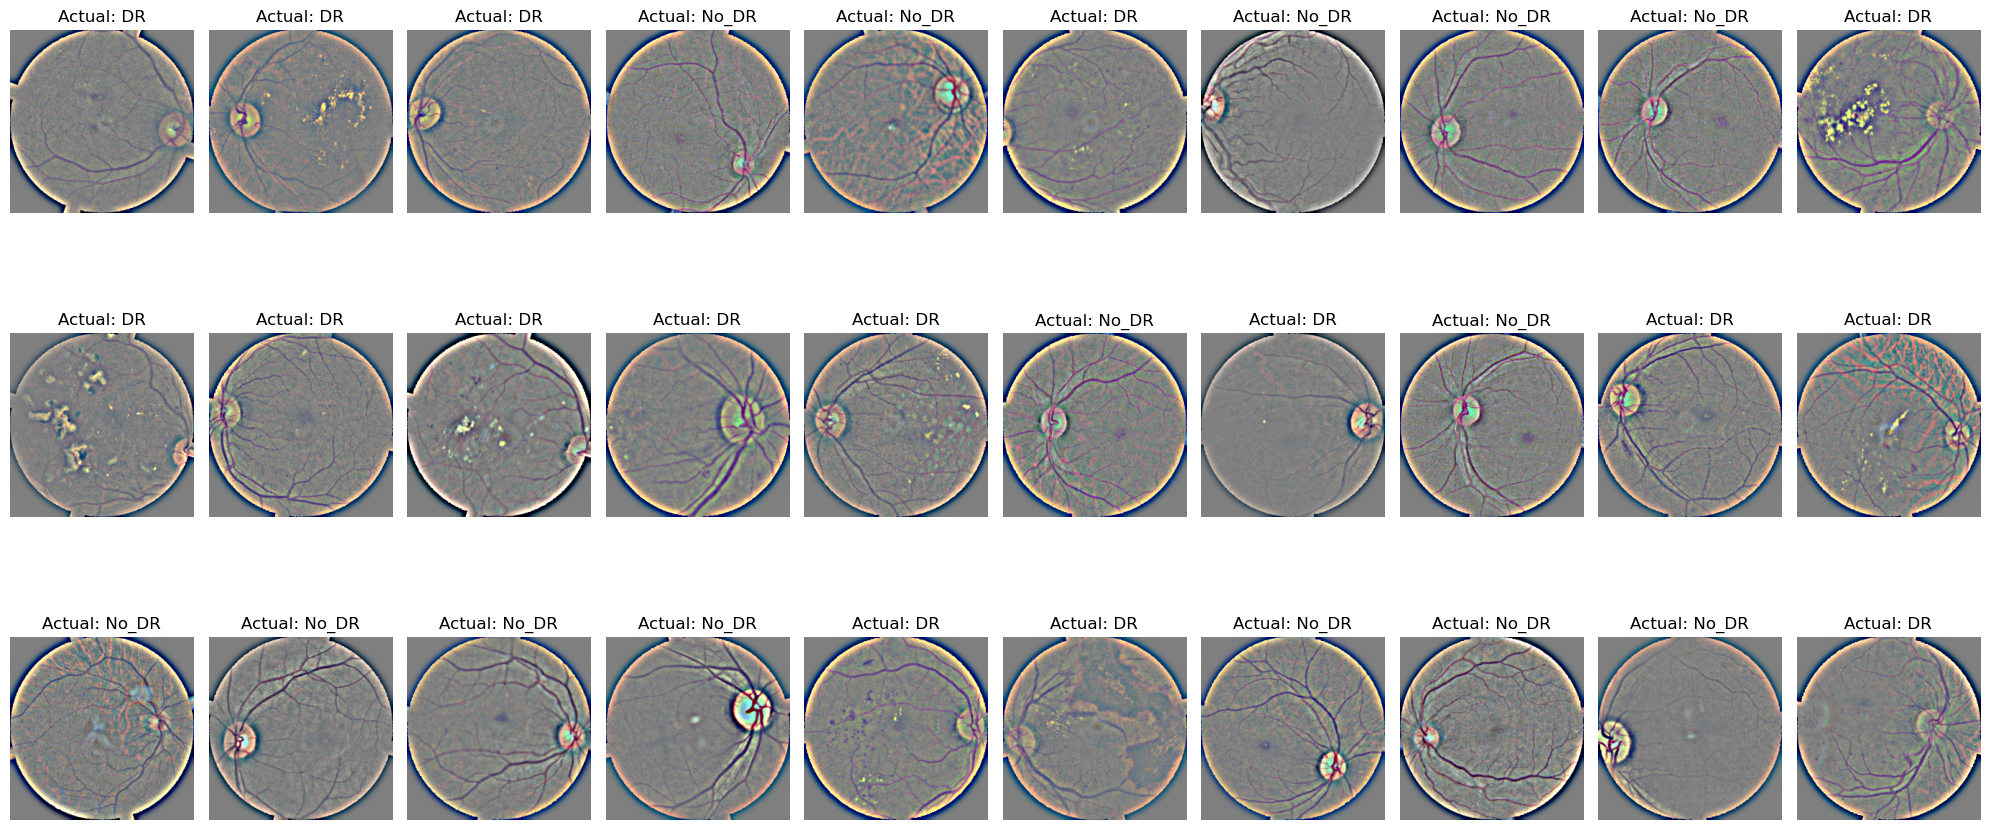

In [11]:
images, labels = train_generator.next()

# Display the first 30 images from the batch
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title('Actual: {}'.format(class_labels[int(labels[i])]))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# for validation 
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = custom_preprocessing
)

In [13]:
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=24,
#     color_mode='grayscale',
)

Found 366 images belonging to 2 classes.


In [14]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = custom_preprocessing
)

In [15]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=24,
)

Found 366 images belonging to 2 classes.


# Model creation

In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import resnet50

In [17]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))#, classes=6)

2023-07-31 10:08:56.551232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
for layer in ResNet50_model.layers:
    layer.trainable = False

In [19]:
model = Sequential()
model.add(ResNet50_model)
model.add(Flatten()),
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               6

In [22]:
from keras.callbacks import ReduceLROnPlateau

In [23]:
# hyper-parameters
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                              verbose=0, mode='auto', min_delta=0.0001,
                              cooldown=0, min_lr=0)
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [24]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 0.9792780748663101, 1: 1.0216178521617851}

In [25]:
h = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCH,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping],
#     class_weight=class_weights

)

Epoch 1/30
91/91 [==============================] - 581s 6s/step - loss: 5.8980 - accuracy: 0.4903 - val_loss: 0.7033 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - 523s 6s/step - loss: 0.8083 - accuracy: 0.5293 - val_loss: 0.7140 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 3/30
91/91 [==============================] - 513s 6s/step - loss: 0.7052 - accuracy: 0.5386 - val_loss: 0.6985 - val_accuracy: 0.5966 - lr: 0.0010
Epoch 4/30
91/91 [==============================] - 525s 6s/step - loss: 0.6846 - accuracy: 0.5597 - val_loss: 0.7118 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 5/30
91/91 [==============================] - 516s 6s/step - loss: 0.6967 - accuracy: 0.5438 - val_loss: 0.6889 - val_accuracy: 0.5824 - lr: 0.0010
Epoch 6/30
91/91 [==============================] - 760s 8s/step - loss: 0.6921 - accuracy: 0.5335 - val_loss: 0.6800 - val_accuracy: 0.6051 - lr: 0.0010
Epoch 7/30
91/91 [==============================] - 777s 8s/step - loss: 0.6

In [26]:
def visualize_performance(history):
    #Visualizing the training performance
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='val_Loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    plt.title('Loss evolution')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy evolution')

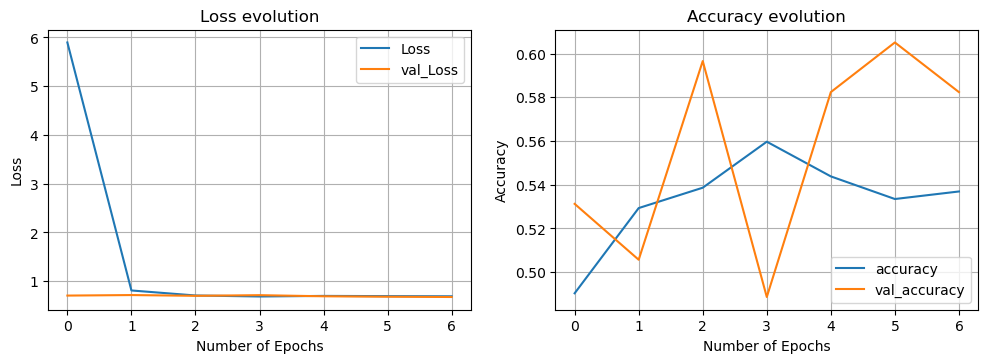

In [27]:
visualize_performance(h)

In [28]:
model.evaluate(test_generator)

12/12 [==============================] - 70s 6s/step - loss: 0.6699 - accuracy: 0.5301


[0.6698906421661377, 0.5300546288490295]

In [29]:
predictions = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
predictions

11/11 [==============================] - 69s 6s/step


array([[0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.46423876],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.47238767],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.4734969 ],
       [0.473

In [30]:
predicted_classes = []
for element in predictions:
    if element > 0.5:
        predicted_classes.append(1)
    else:
        predicted_classes.append(0)
    
predicted_classes[:30]
# predicted_classes = [np.argmax(pred) for pred in predictions]
# predicted_classes[:30]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [31]:
true_classes = test_generator.classes
true_classes[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [32]:
class_labels_test_data = list(test_generator.class_indices.keys())
class_labels_test_data

['DR', 'No_DR']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

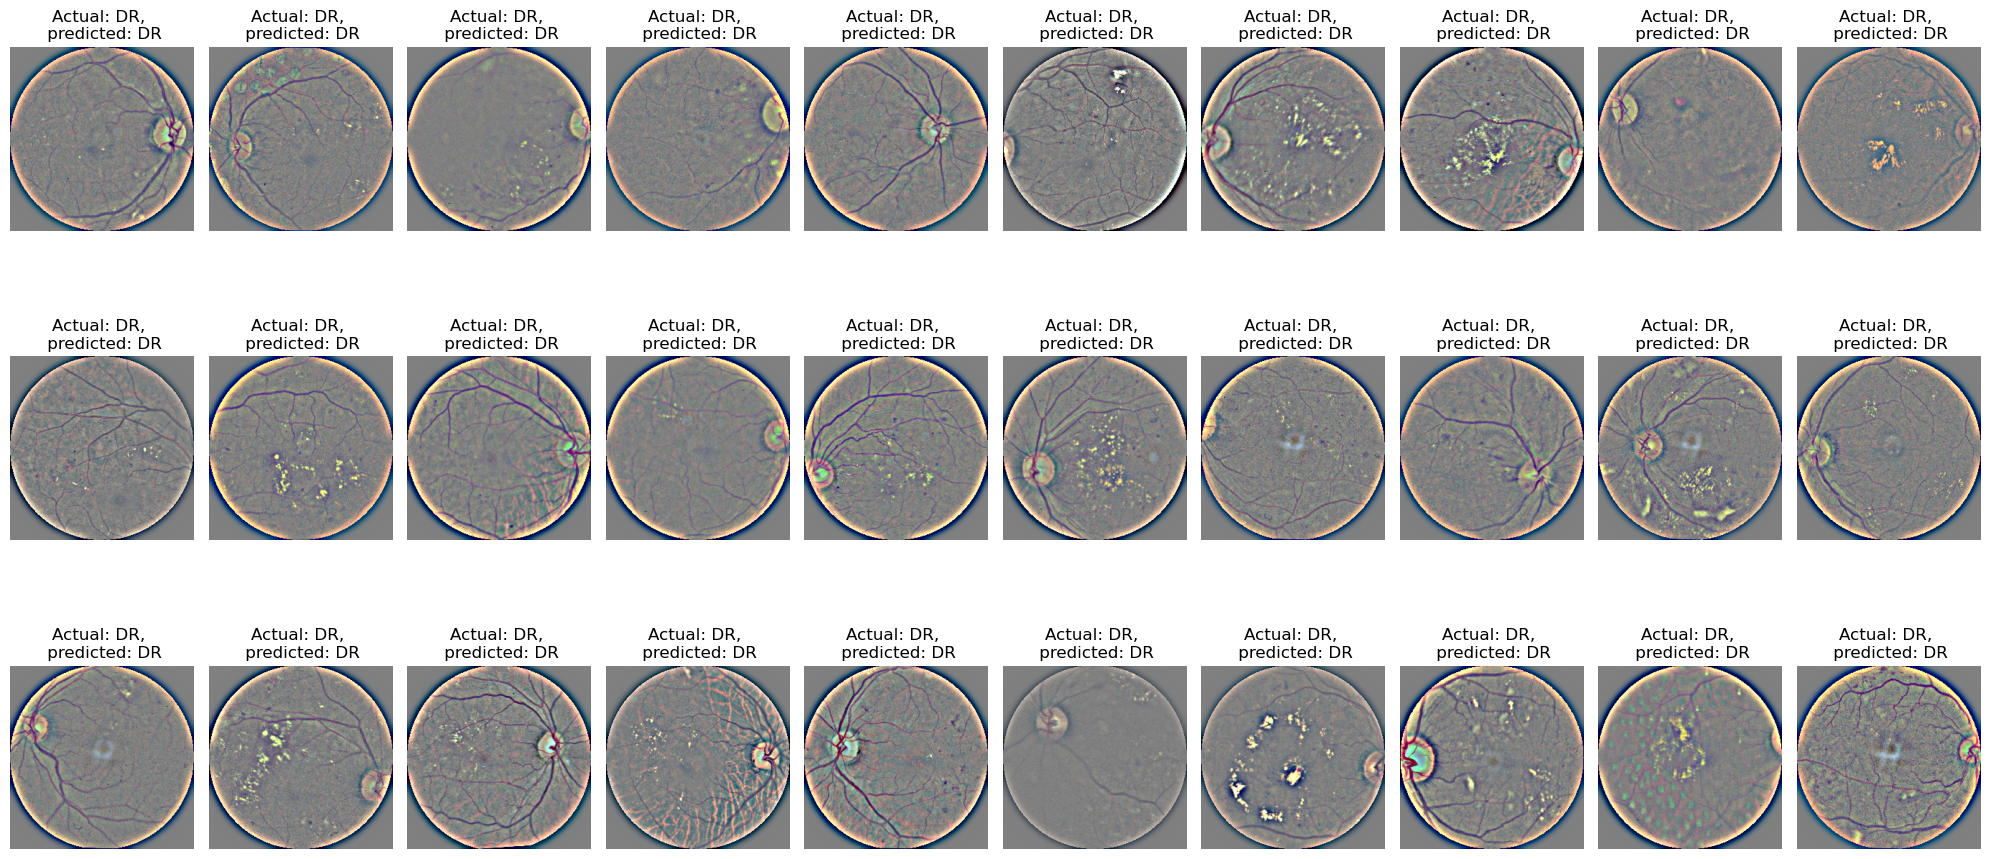

In [33]:
# Get the next batch of images and labels from the generator
images, labels = test_generator.next()

# Display the first 30 images from the batch
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title('Actual: {}'.format(class_labels_test_data[int(labels[i])])+', \n predicted: {}'.format(class_labels_test_data[predicted_classes[i]]))
    ax.axis('off')

plt.tight_layout()
plt.show()

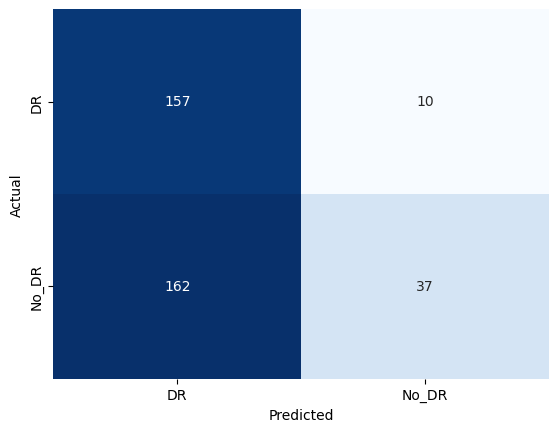

In [34]:
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_test_data, yticklabels= class_labels_test_data, cbar = False, cmap = plt.cm.Blues,)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

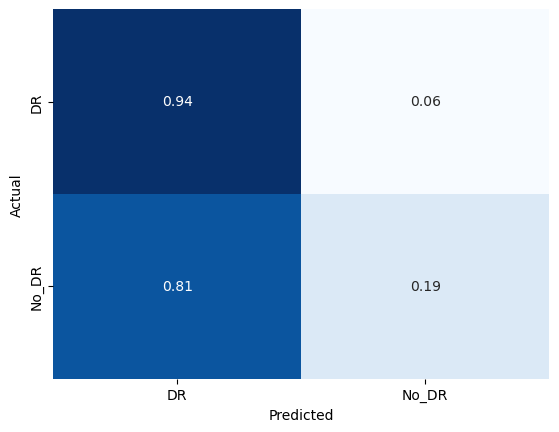

In [35]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_labels_test_data, yticklabels=class_labels_test_data, cbar = False,cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [36]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

          DR       0.49      0.94      0.65       167
       No_DR       0.79      0.19      0.30       199

    accuracy                           0.53       366
   macro avg       0.64      0.56      0.47       366
weighted avg       0.65      0.53      0.46       366



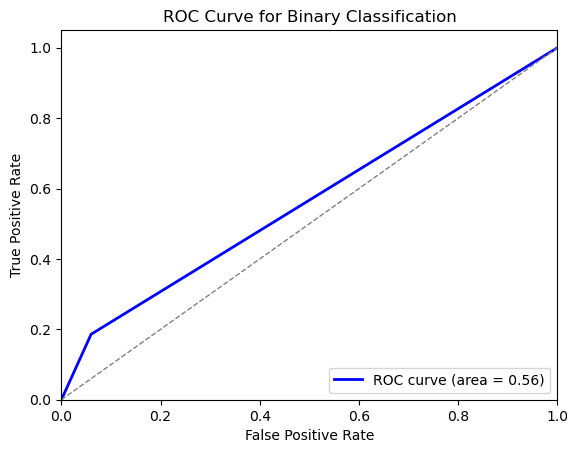

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

num_classes = 2 
predicted_probs = np.zeros((len(predicted_classes), num_classes))
predicted_probs[np.arange(len(predicted_classes)), predicted_classes] = 1

# Compute the ROC curve
fpr, tpr, _ = roc_curve(true_classes, predicted_probs[:, 1])  # Use probabilities of the positive class

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc='lower right')
plt.show()


## Roc Curve

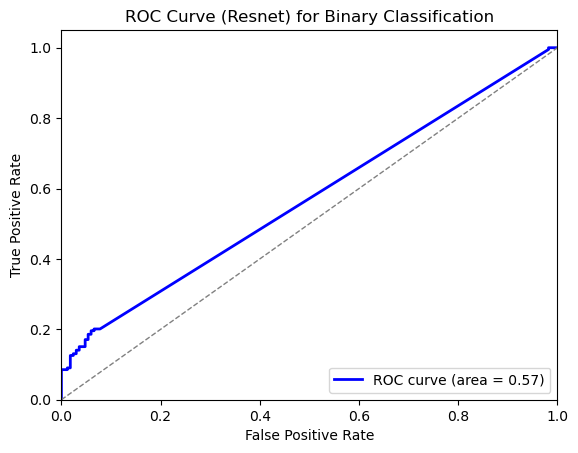

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc




# Compute the ROC curve
fpr, tpr, _ = roc_curve(true_classes, predictions)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Resnet) for Binary Classification')
plt.legend(loc='lower right')
plt.show()
